# Adding Space

### The Boltzmann Wealth Model

If you want to get straight to the tutorial checkout these environment providers:<br>
(with Google Account) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/projectmesa/mesa/blob/main/docs/tutorials/1_adding_space.ipynb)<br>
(no Google Account)   [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/projectmesa/mesa/main?labpath=docs%2Ftutorials%2F1_adding_space.ipynb) (This can take 30 seconds to 5 minutes to load)

*If you are running locally, please ensure you have the latest Mesa version installed.*

## Tutorial Description

This tutorial extends the Boltzmann wealth model from the [Running Your First Model tutorial](https://mesa.readthedocs.io/latest/tutorials/0_first_model.html), by adding Mesa's discrete space module.

In this portion, `MoneyAgent`s will move in a two dimensional grid, made up of discrete cells and randomly exchange money with other agents.

*If you are starting here please see the [Running Your First Model tutorial](https://mesa.readthedocs.io/latest/tutorials/0_first_model.html) for dependency and start-up instructions*

### IN COLAB? - Run the next cell

### Import Dependencies
This includes importing of dependencies needed for the tutorial.

In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa

## Base Model

The below provides the base model from which we will add our space functionality.

This is from the [Running Your First Model tutorial](https://mesa.readthedocs.io/latest/tutorials/0_first_model.html) tutorial. If you have any questions about it functionality please review that tutorial.

In [2]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def exchange(self):
        # Verify agent has some wealth
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

    def step(self):
        """Advance the model by one step."""
        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.shuffle_do("exchange")

In [3]:
# Execute the model
model = MoneyModel(10)
model.step()
# Make sure it worked
print(f"You have {len(model.agents)} agents.")

You have 10 agents.


## Adding space

**Background:** Due to the complex dynamics of space and movement, Mesa offers a wide range space options and has built a structure to allow for the addition of even more spaces or custom user space creation. (Please contribute to Mesa if you develop a new space that can add to user options.)

The two main approaches to space are discrete space (think cells or nodes that agents occupy) and continuous space (agents can occupy any location(s) in a three-dimensional space). Continuous space is still experimental as we continue to develop it.

**Overview of Discrete Space:** For this tutorial we will be using discrete space in the classic cartesian coordinated system. As indicated in the diagram discrete space is made up of two modules. Cells and Cell Agents.

**Cells:**
The cell class represents a location that can:
- Have properties (like temperature or resources)
- Track and limit the agents it contains
- Connect to neighboring cells
- Provide neighborhood information

Cells form the foundation of the cell space system, enabling rich spatial environments where both location properties and agent behaviors matter. They're useful for modeling things like varying terrain, infrastructure capacity, or environmental conditions.

**Cell Agents:**
Agents that understand how to exist in and move through cell spaces.

Cell Agents are specialized agent classes that handle cell occupation, movement, and proper registration:
- `CellAgent`: Mobile agents that can move between cells
- `FixedAgent`: Immobile agents permanently fixed to cells
- `Grid2DMovingAgent`: Agents with grid-specific movement capabilities

These classes ensure consistent agent-cell relationships and proper state management as agents move through the space. They can be used directly or as examples for creating custom cell-aware agents.

From these basic building blocks we can then add features to allow for different types of spaces and behaviors. To keep this tutorial concise we will not go through all of them, however, the current layout of discrete space is below as well as the different support modules. To find out more about the other options and what they can do, check out the [Discrete Space API](https://mesa.readthedocs.io/latest/apis/discrete_space.html)

<br><br>
![Discerete Space Diagram](https://github.com/projectmesa/mesa/blob/main/docs/images/Discrete_Space.drawio.png?raw=1)
<br>

*A big thanks to maintainer qualquel and his creation of this exceptional space dynamic.*


**Model-specific information:**  In addition to using discrete space, the agents will access their [Moore neighborhood](https://en.wikipedia.org/wiki/Moore_neighborhood). A Moore neighborhood means agents can interact with 8 neighbors.  Instead of giving their unit of money to any random agent, they'll give it to an agent on the same cell. For the Money model multiple agents can be in the same spaces and since they are on a torus the agents on the left side can exchange money with agent on the right. Agents on the top can exchange with agents on the bottom.

#### Code Implementation

To ensure we give our agents discrete space functionality we now instantiate our `MoneyAgent`s as `CellAgent`s. `Cell Agent` is a subclass to Mesa's `Agent` class that is specifically built to interact and move within the `discrete space` module.  

Below highlights each of the changes to the base code to add space and movement of agents.

**Imports**<br>
\# Import Cell Agent and OrthogonalMooreGrid
- *Description:* Import the cell agent class and a specific grid construct the OrthognalMooreGrid.
- *API*: [CellAgent](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.__init__.CellAgent) and [OrthogonalMooreGrid](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.grid.OrthogonalMooreGrid)

**MoneyAgent Class**<br>
\# Instantiate MoneyAgent as CellAgent
- *Description:* `MoneyAgent` inherits `CellAgent`, a subclass of `Agent`.
- *API*: [CellAgent](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.__init__.CellAgent)

\# Instantiate agent with location (x,y)
- *Description:* Pass the cell object as a parameter to the agent to give the agent a location
- *API*: N/A

\# Move function
- *Description:* Update the agents cell through methods in Mesa's discrete_space module `neighborhood`, which defaults to radius one and `select_random_cell` which selects a random cell for the provided neighborhood
- *API*: [neighborhood](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.__init__.Cell.neighborhood) and [select_random_cell](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.__init__.CellCollection.select_random_cell)

**MoneyModel Class**<br>
\# Instantiate an instance of Moore neighborhood space
- *Description:* Instantiate a OrthgonalMooreGrid as `self.grid` with passing in the parameters width and height as a tuple, torus as True, a cell capacity of 5 agents, and the models random seed to the discrete space
- *API*: [OrthogonalMooreGrid](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.grid.OrthogonalMooreGrid)

\# Randomly select agents cell
- *Description:* Use Python's `random.choices` and pass in all cells with discrete space all_cells properties and the number of choices `k` to assign each agent a location.  
- *API*: [random.choices](https://docs.python.org/3/library/random.html#random.choices) and [all_cells](https://mesa.readthedocs.io/latest/apis/discrete_space.html#id1)

In [4]:
# Import Cell Agent and OrthogonalMooreGrid
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid


# Instantiate MoneyAgent as CellAgent
class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell  # Instantiate agent with location (x,y)
        self.wealth = 1

    # Move Function
    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [
            a for a in self.cell.agents if a is not self
        ]  # Get all agents in cell

        if self.wealth > 0 and cellmates:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        # Instantiate an instance of Moore neighborhood space
        self.grid = OrthogonalMooreGrid(
            (width, height), torus=True, capacity=10, random=self.random
        )

        # Create agents
        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            # Randomly select agents cell
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

Let's create a model with 100 agents on a 10x10 grid, and run it for 20 steps.

In [5]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

Now let's use seaborn and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros.

Then again use `all_cells` to loop over every cell in the grid, giving us each cell's position (cell coordinate attribute) and its contents (cell agent attribute).

[Cell API](https://mesa.readthedocs.io/latest/apis/discrete_space.html#mesa.discrete_space.__init__.Cell)

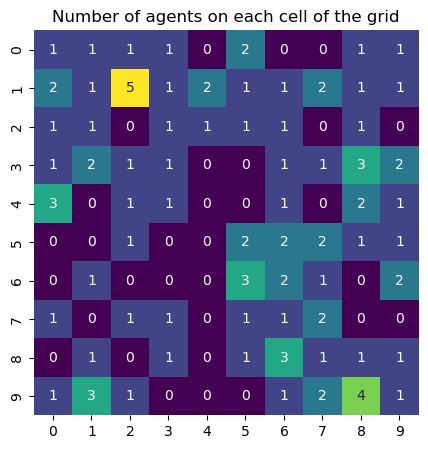

In [6]:
agent_counts = np.zeros((model.grid.width, model.grid.height))

for cell in model.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

## Next Steps

Check out the [collecting data tutorial](https://mesa.readthedocs.io/latest/tutorials/2_collecting_data_tutorial.html) on how to collect data form your model.

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.